In [1]:
import os
import rasterio
import pandas as pd
import numpy as np

# Path to the directory containing the .tif files
data_dir = r"C:\Users\administrateur\NASA-PROJECT\resources\\"

# Create an empty list to store the data from all years
all_data = []

# Loop through all .tif files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith('.tif'):
        # Extract the year from the filename 
        year = filename.split('_')[-1][:4]  # Extract the year from the filename
        print(f"Processing year: {year}")  # To ensure the year is extracted correctly
        
        # Load the .tif file using rasterio
        filepath = os.path.join(data_dir, filename)
        with rasterio.open(filepath) as src:
            # Read the emissions data (assuming single-band data)
            data = src.read(1)  # Reading the first band
            
            # Get the latitude and longitude of each pixel
            rows, cols = np.indices(data.shape)
            lon, lat = rasterio.transform.xy(src.transform, rows, cols, offset='center')
            
            # Flatten the arrays
            lon = np.array(lon).flatten()
            lat = np.array(lat).flatten()
            values = data.flatten()

            # Create a DataFrame for this year
            df = pd.DataFrame({
                'Longitude': lon,
                'Latitude': lat,
                'Value': values
            })
            
            # Assign the year as a new column (the year as the timestamp)
            df['Date'] = pd.Timestamp(f'{year}-01-01')
            
            # Append this year's data to the list
            all_data.append(df)

# Concatenate all the yearly DataFrames into one
emissions_near_earthquakes = pd.concat(all_data, ignore_index=True)

# Check the structure of the emissions data
print(emissions_near_earthquakes.head())


Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
   Longitude  Latitude   Value       Date
0     -179.5      89.5 -9999.0 2015-01-01
1     -178.5      89.5 -9999.0 2015-01-01
2     -177.5      89.5 -9999.0 2015-01-01
3     -176.5      89.5 -9999.0 2015-01-01
4     -175.5      89.5 -9999.0 2015-01-01


In [2]:
# Filter out invalid emissions values (Value == -9999.0)
emissions_near_earthquakes_clean = emissions_near_earthquakes[emissions_near_earthquakes['Value'] != -9999.0]

# Check the cleaned data
print(emissions_near_earthquakes_clean.head())


      Longitude  Latitude         Value       Date
2260      -79.5      83.5  1.956606e-07 2015-01-01
2261      -78.5      83.5  6.236824e-08 2015-01-01
2262      -77.5      83.5  1.843677e-07 2015-01-01
2263      -76.5      83.5  6.893937e-07 2015-01-01
2264      -75.5      83.5  6.770272e-07 2015-01-01


In [4]:
# Load the earthquake data
earthquake_df = pd.read_csv('IEB_export.csv')

# Combine the 'Year', 'Month', and 'Day' columns into a single 'Date' column
earthquake_df['Date'] = pd.to_datetime(earthquake_df[['Year', 'Month', 'Day']])

# Extract the year from the 'Date' column
earthquake_df['Year'] = earthquake_df['Date'].dt.year

# Check the earthquake data
print(earthquake_df[['Lat', 'Lon', 'Date', 'Year']].head())


       Lat      Lon       Date  Year
0 -31.5729 -71.6744 2015-09-16  2015
1  15.0222 -93.8993 2017-09-08  2017
2  -5.8119 -75.2697 2019-05-26  2019
3  -4.9521  94.3299 2016-03-02  2016
4   0.3819 -79.9218 2016-04-16  2016


In [11]:
import numpy as np

# Vectorized Haversine function using NumPy
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Create a list to store emissions data near earthquakes
emissions_list = []

# Loop through each earthquake and calculate the distance to each emissions data point
for index, quake in earthquake_df.iterrows():
    quake_lat = quake['Lat']
    quake_lon = quake['Lon']
    
    # Vectorized distance calculation for all emissions data points at once
    emissions_near_earthquakes_clean_copy = emissions_near_earthquakes_clean.copy()
    
    # Vectorized Haversine calculation for all rows at once
    emissions_near_earthquakes_clean_copy['distance_to_earthquake'] = haversine_vectorized(
        emissions_near_earthquakes_clean_copy['Latitude'], emissions_near_earthquakes_clean_copy['Longitude'], quake_lat, quake_lon)
    
    # Filter emissions data points within the distance threshold
    emissions_near_quake = emissions_near_earthquakes_clean_copy[emissions_near_earthquakes_clean_copy['distance_to_earthquake'] <= distance_threshold]
    
    # Add filtered emissions data to the list
    emissions_list.append(emissions_near_quake)

# Concatenate all the DataFrames in the list into one DataFrame
emissions_near_earthquakes_final = pd.concat(emissions_list, ignore_index=True)

# Check the final result
print(emissions_near_earthquakes_final.head())


   Longitude  Latitude     Value       Date  distance_to_earthquake
0      -71.5     -31.5  1.088069 2015-01-01                18.40905
1      -71.5     -31.5  1.026148 2016-01-01                18.40905
2      -71.5     -31.5  0.972082 2017-01-01                18.40905
3      -71.5     -31.5  1.035824 2018-01-01                18.40905
4      -71.5     -31.5  1.149445 2019-01-01                18.40905


Date
2015-01-01   -2.752817
2016-01-01   -2.653381
2017-01-01   -2.573892
2018-01-01   -2.306159
2019-01-01   -2.495458
2020-01-01   -2.849295
Name: Value, dtype: float64


<AxesSubplot:title={'center':'Emissions Over Time'}, xlabel='Date', ylabel='Mean Emissions Value'>

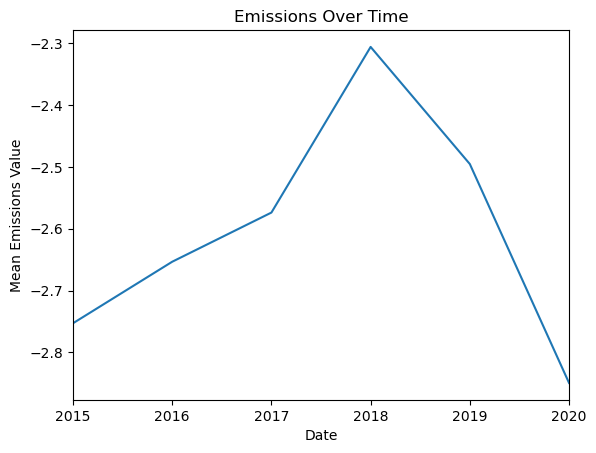

In [12]:
# Group by the 'Date' and calculate mean emissions Value for each year
emissions_by_year = emissions_near_earthquakes_final.groupby('Date')['Value'].mean()

# Print the yearly emissions
print(emissions_by_year)

# Plot the emissions over time
emissions_by_year.plot(kind='line', title='Emissions Over Time', ylabel='Mean Emissions Value')


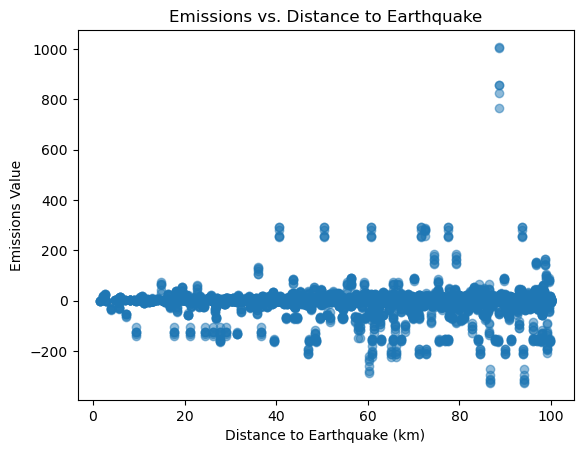

In [13]:
import matplotlib.pyplot as plt

# Plot emissions values against their distance from earthquakes
plt.scatter(emissions_near_earthquakes_final['distance_to_earthquake'], emissions_near_earthquakes_final['Value'], alpha=0.5)
plt.title('Emissions vs. Distance to Earthquake')
plt.xlabel('Distance to Earthquake (km)')
plt.ylabel('Emissions Value')
plt.show()


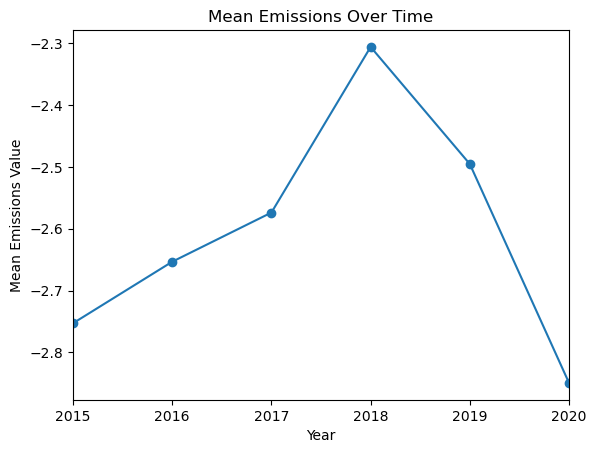

In [14]:
import matplotlib.pyplot as plt

# Plot the mean emissions values over time
emissions_by_year.plot(kind='line', marker='o', title='Mean Emissions Over Time', ylabel='Mean Emissions Value', xlabel='Year')

# Show the plot
plt.show()

In [16]:
import matplotlib.pyplot as plt

# Define the time window (e.g., 30 days before and after each earthquake)
time_window = pd.Timedelta(days=30)

# Create an empty DataFrame to store the emissions around earthquake events
emissions_around_earthquake = pd.DataFrame()

# Loop through each earthquake event
for index, quake in earthquake_df.iterrows():
    quake_date = quake['Date']
    
    # Filter emissions data within the time window around the earthquake
    emissions_before_after = emissions_near_earthquakes_final[
        (emissions_near_earthquakes_final['Date'] >= quake_date - time_window) & 
        (emissions_near_earthquakes_final['Date'] <= quake_date + time_window)
    ]
    
    # Add the earthquake date to the emissions data for reference
    emissions_before_after['Earthquake_Date'] = quake_date
    
    # Append the filtered data to the final DataFrame
    emissions_around_earthquake = pd.concat([emissions_around_earthquake, emissions_before_after])

# Check the structure of the emissions data around earthquakes
print(emissions_around_earthquake.head())


C:\Users\administrateur\AppData\Local\Temp\ipykernel_25860\1288920142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emissions_before_after['Earthquake_Date'] = quake_date
C:\Users\administrateur\AppData\Local\Temp\ipykernel_25860\1288920142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emissions_before_after['Earthquake_Date'] = quake_date
C:\Users\administrateur\AppData\Local\Temp\ipykernel_25860\1288920142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

    Longitude  Latitude     Value       Date  distance_to_earthquake  \
5       -71.5     -31.5  1.038483 2020-01-01               18.409050   
11      -93.5      15.5  2.420369 2020-01-01               68.245572   
27      -75.5      -5.5  0.510671 2020-01-01               43.037523   
28      -74.5      -5.5  0.404591 2020-01-01               91.960541   
29      -75.5      -6.5  0.862389 2020-01-01               80.638109   

   Earthquake_Date  
5       2020-01-28  
11      2020-01-28  
27      2020-01-28  
28      2020-01-28  
29      2020-01-28  


C:\Users\administrateur\AppData\Local\Temp\ipykernel_25860\1288920142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emissions_before_after['Earthquake_Date'] = quake_date
C:\Users\administrateur\AppData\Local\Temp\ipykernel_25860\1288920142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emissions_before_after['Earthquake_Date'] = quake_date
C:\Users\administrateur\AppData\Local\Temp\ipykernel_25860\1288920142.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

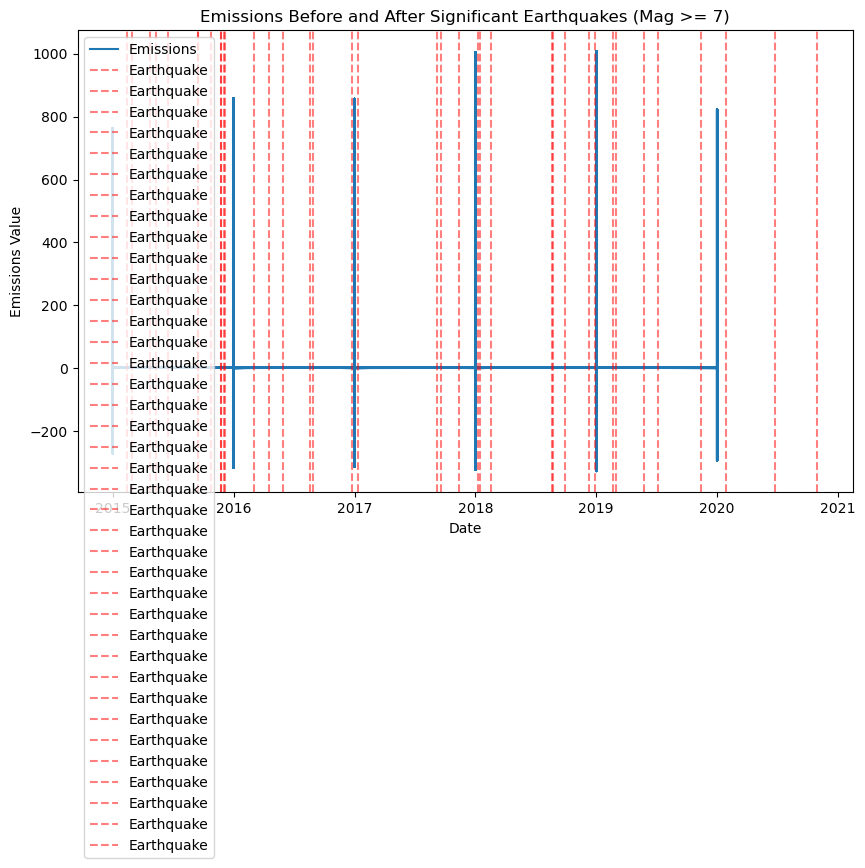

In [18]:
# Set the magnitude threshold (e.g., only show earthquakes with magnitude >= 7)
magnitude_threshold = 7.0

# Filter earthquakes based on magnitude
filtered_earthquake_df = earthquake_df[earthquake_df['Mag'] >= magnitude_threshold]

# Plot emissions and filtered earthquakes
plt.figure(figsize=(10, 6))

# Plot emissions values
plt.plot(emissions_around_earthquake['Date'], emissions_around_earthquake['Value'], label='Emissions')

# Add filtered earthquake events as vertical lines
for quake_date in filtered_earthquake_df['Date']:
    plt.axvline(x=quake_date, color='red', linestyle='--', alpha=0.5, label='Earthquake')

# Add labels and title
plt.title('Emissions Before and After Significant Earthquakes (Mag >= 7)')
plt.xlabel('Date')
plt.ylabel('Emissions Value')
plt.legend()

# Show the plot
plt.show()


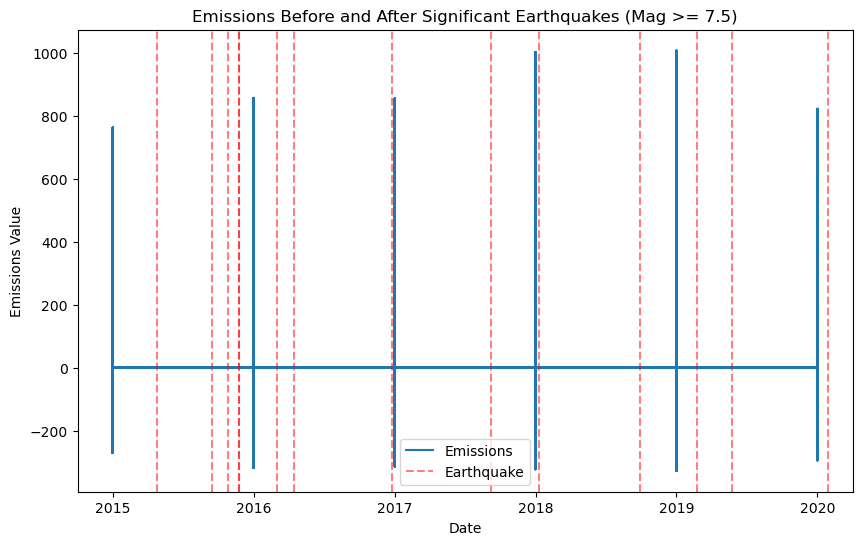

In [19]:
# Set a higher magnitude threshold (e.g., magnitude ≥ 7.5)
magnitude_threshold = 7.5

# Filter earthquakes based on magnitude
filtered_earthquake_df = earthquake_df[earthquake_df['Mag'] >= magnitude_threshold]

# Plot emissions and filtered earthquakes
plt.figure(figsize=(10, 6))

# Plot emissions values
plt.plot(emissions_around_earthquake['Date'], emissions_around_earthquake['Value'], label='Emissions')

# Add filtered earthquake events as vertical lines (only one 'Earthquake' label in legend)
for i, quake_date in enumerate(filtered_earthquake_df['Date']):
    if i == 0:
        plt.axvline(x=quake_date, color='red', linestyle='--', alpha=0.5, label='Earthquake')  # First line with label
    else:
        plt.axvline(x=quake_date, color='red', linestyle='--', alpha=0.5)  # No label for subsequent lines

# Add labels and title
plt.title('Emissions Before and After Significant Earthquakes (Mag >= 7.5)')
plt.xlabel('Date')
plt.ylabel('Emissions Value')
plt.legend()

# Show the plot
plt.show()


## Observations:
Spikes in Emissions: It seems that there are a few visible spikes in the emissions data, which may correlate with the earthquake events.
Negative Values: There are both positive and negative emissions values, which could indicate regions of carbon absorption or other data irregularities.

In [22]:
# Define latitude and longitude bounds for the region (e.g., North America)
lat_min, lat_max = 20, 60
lon_min, lon_max = -130, -60

# Filter the earthquake data for the region
regional_earthquake_df = filtered_earthquake_df[
    (filtered_earthquake_df['Lat'] >= lat_min) & (filtered_earthquake_df['Lat'] <= lat_max) &
    (filtered_earthquake_df['Lon'] >= lon_min) & (filtered_earthquake_df['Lon'] <= lon_max)
]

# Filter the emissions data for the same region
regional_emissions_df = emissions_near_earthquakes_final[
    (emissions_near_earthquakes_final['Latitude'] >= lat_min) & (emissions_near_earthquakes_final['Latitude'] <= lat_max) &
    (emissions_near_earthquakes_final['Longitude'] >= lon_min) & (emissions_near_earthquakes_final['Longitude'] <= lon_max)
]

# Check the filtered data
print(f"Filtered Earthquake Data (Region): {regional_earthquake_df.shape}")
print(f"Filtered Emissions Data (Region): {regional_emissions_df.shape}")


Filtered Earthquake Data (Region): (0, 11)
Filtered Emissions Data (Region): (288, 5)


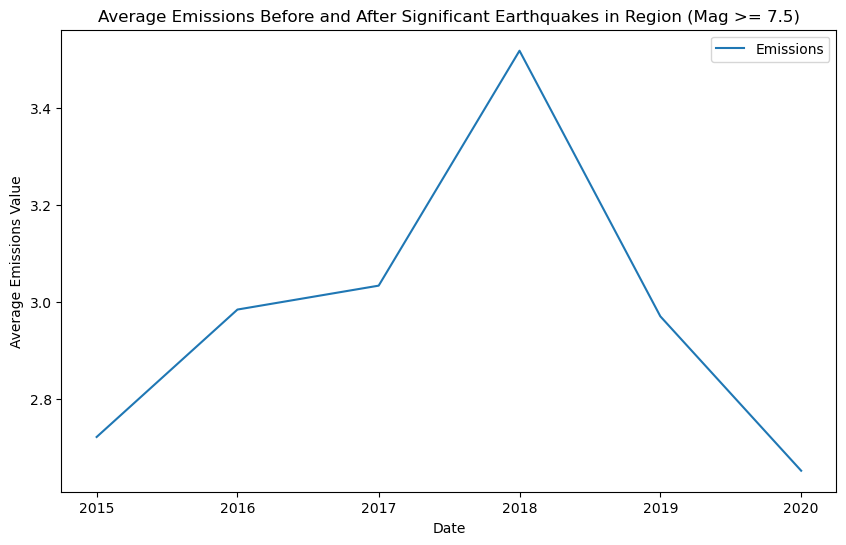

In [25]:
# Group emissions by date and calculate the mean for each date
grouped_emissions = regional_emissions_df.groupby('Date')['Value'].mean().reset_index()

# Plot the grouped emissions data
plt.figure(figsize=(10, 6))
plt.plot(grouped_emissions['Date'], grouped_emissions['Value'], label='Emissions')

# Add labels and title
plt.title('Average Emissions Before and After Significant Earthquakes in Region (Mag >= 7.5)')
plt.xlabel('Date')
plt.ylabel('Average Emissions Value')
plt.legend()

# Show the plot
plt.show()


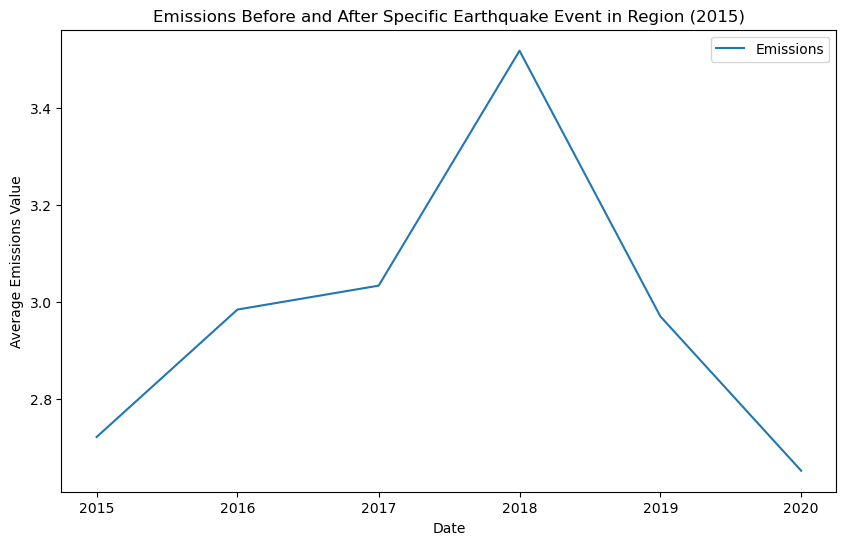

In [26]:
# Filter the earthquake data for a specific year or event
specific_event_df = regional_earthquake_df[regional_earthquake_df['Year'] == 2015]  # Example for 2015

# Plot emissions values and specific earthquake event
plt.figure(figsize=(10, 6))
plt.plot(grouped_emissions['Date'], grouped_emissions['Value'], label='Emissions')

for quake_date in specific_event_df['Date']:
    plt.axvline(x=quake_date, color='red', linestyle='--', alpha=0.5, label='Earthquake')

# Add labels and title
plt.title('Emissions Before and After Specific Earthquake Event in Region (2015)')
plt.xlabel('Date')
plt.ylabel('Average Emissions Value')
plt.legend()

# Show the plot
plt.show()


In [27]:
pip install geopandas matplotlib

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Define latitude and longitude bounds for the region (e.g., North America)
lat_min, lat_max = 20, 60
lon_min, lon_max = -130, -60
magnitude_threshold = 7.5

# Filter the earthquake data for the region and magnitude threshold
regional_earthquake_df = filtered_earthquake_df[
    (filtered_earthquake_df['Lat'] >= lat_min) & (filtered_earthquake_df['Lat'] <= lat_max) &
    (filtered_earthquake_df['Lon'] >= lon_min) & (filtered_earthquake_df['Lon'] <= lon_max) &
    (filtered_earthquake_df['Mag'] >= magnitude_threshold)
]

# Filter the emissions data for the same region
regional_emissions_df = emissions_near_earthquakes_final[
    (emissions_near_earthquakes_final['Latitude'] >= lat_min) & (emissions_near_earthquakes_final['Latitude'] <= lat_max) &
    (emissions_near_earthquakes_final['Longitude'] >= lon_min) & (emissions_near_earthquakes_final['Longitude'] <= lon_max)
]


In [31]:
# Check if the filtered earthquake and emissions data contain data
print(f"Filtered Earthquake Data (Region): {regional_earthquake_df.shape}")
print(f"Filtered Emissions Data (Region): {regional_emissions_df.shape}")

# If no data is present in either DataFrame, print a message
if regional_earthquake_df.empty:
    print("No earthquake data available for this region.")
if regional_emissions_df.empty:
    print("No emissions data available for this region.")


Filtered Earthquake Data (Region): (0, 11)
Filtered Emissions Data (Region): (288, 5)
No earthquake data available for this region.


Filtered Earthquake Data (Region): (1, 11)
Filtered Emissions Data (Region): (2742, 5)


c:\Users\administrateur\Anaconda3\lib\site-packages\matplotlib\collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\administrateur\Anaconda3\lib\site-packages\matplotlib\collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


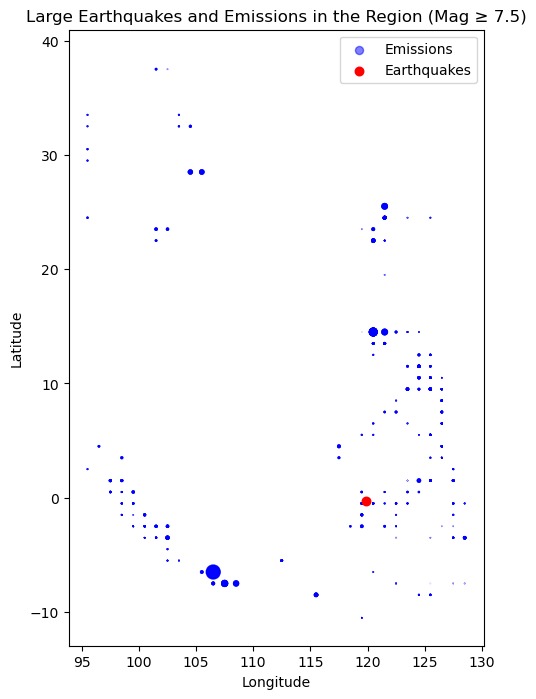

In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Adjust the latitude and longitude bounds for the region (you can change these)
# Example: North America or another region with high seismic activity
lat_min, lat_max = -15, 45  # Latitude range
lon_min, lon_max = 95, 160  # Longitude range
magnitude_threshold = 7.5  # Filter earthquakes with magnitude >= 7.5

# Filter the earthquake data for the region and magnitude threshold
regional_earthquake_df = filtered_earthquake_df[
    (filtered_earthquake_df['Lat'] >= lat_min) & (filtered_earthquake_df['Lat'] <= lat_max) &
    (filtered_earthquake_df['Lon'] >= lon_min) & (filtered_earthquake_df['Lon'] <= lon_max) &
    (filtered_earthquake_df['Mag'] >= magnitude_threshold)
]

# Filter the emissions data for the same region
regional_emissions_df = emissions_near_earthquakes_final[
    (emissions_near_earthquakes_final['Latitude'] >= lat_min) & (emissions_near_earthquakes_final['Latitude'] <= lat_max) &
    (emissions_near_earthquakes_final['Longitude'] >= lon_min) & (emissions_near_earthquakes_final['Longitude'] <= lon_max)
]

# Check if the filtered earthquake and emissions data contain data
print(f"Filtered Earthquake Data (Region): {regional_earthquake_df.shape}")
print(f"Filtered Emissions Data (Region): {regional_emissions_df.shape}")

# If no data is present in either DataFrame, print a message
if regional_earthquake_df.empty:
    print("No earthquake data available for this region.")
if regional_emissions_df.empty:
    print("No emissions data available for this region.")

# Proceed only if there is data available for both earthquakes and emissions
if not regional_earthquake_df.empty and not regional_emissions_df.empty:
    # Create GeoDataFrames for earthquakes and emissions
    earthquake_gdf = gpd.GeoDataFrame(
        regional_earthquake_df,
        geometry=gpd.points_from_xy(regional_earthquake_df['Lon'], regional_earthquake_df['Lat'])
    )

    emissions_gdf = gpd.GeoDataFrame(
        regional_emissions_df,
        geometry=gpd.points_from_xy(regional_emissions_df['Longitude'], regional_emissions_df['Latitude'])
    )

    # Plot the earthquakes and emissions on a map
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot emissions data with a color map (based on emissions values)
    emissions_gdf.plot(
        ax=ax, 
        marker='o', 
        color='blue', 
        alpha=0.5, 
        label='Emissions', 
        markersize=emissions_gdf['Value'] / emissions_gdf['Value'].max() * 100  # Size by emissions value
    )

    # Plot earthquake locations, sized by magnitude
    earthquake_gdf.plot(
        ax=ax, 
        marker='o', 
        color='red', 
        markersize=earthquake_gdf['Mag'] * 5,  # Size by magnitude
        label='Earthquakes'
    )

    # Add labels and title
    plt.title('Large Earthquakes and Emissions in the Region (Mag ≥ 7.5)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()

    # Show the plot
    plt.show()
else:
    print("Insufficient data for plotting.")


Filtered Earthquake Data (Region): (1, 11)
Filtered Emissions Data (Region): (2742, 5)


c:\Users\administrateur\Anaconda3\lib\site-packages\matplotlib\collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\administrateur\Anaconda3\lib\site-packages\matplotlib\collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


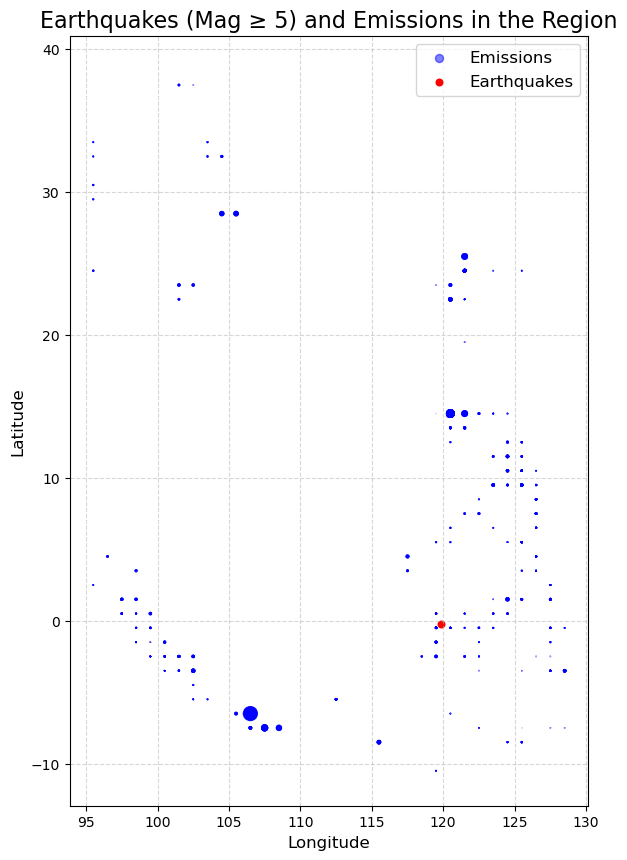

In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Adjust the latitude and longitude bounds for the region

lat_min, lat_max = -15, 45  # Latitude range
lon_min, lon_max = 95, 160  # Longitude range
magnitude_threshold = 5.0  # Lower the threshold to include earthquakes with magnitude >= 5.0

# Filter the earthquake data for the region and magnitude threshold
regional_earthquake_df = filtered_earthquake_df[
    (filtered_earthquake_df['Lat'] >= lat_min) & (filtered_earthquake_df['Lat'] <= lat_max) &
    (filtered_earthquake_df['Lon'] >= lon_min) & (filtered_earthquake_df['Lon'] <= lon_max) &
    (filtered_earthquake_df['Mag'] >= magnitude_threshold)
]

# Filter the emissions data for the same region
regional_emissions_df = emissions_near_earthquakes_final[
    (emissions_near_earthquakes_final['Latitude'] >= lat_min) & (emissions_near_earthquakes_final['Latitude'] <= lat_max) &
    (emissions_near_earthquakes_final['Longitude'] >= lon_min) & (emissions_near_earthquakes_final['Longitude'] <= lon_max)
]

# Check if the filtered earthquake and emissions data contain data
print(f"Filtered Earthquake Data (Region): {regional_earthquake_df.shape}")
print(f"Filtered Emissions Data (Region): {regional_emissions_df.shape}")

if not regional_earthquake_df.empty and not regional_emissions_df.empty:
    # Create GeoDataFrames for earthquakes and emissions
    earthquake_gdf = gpd.GeoDataFrame(
        regional_earthquake_df,
        geometry=gpd.points_from_xy(regional_earthquake_df['Lon'], regional_earthquake_df['Lat'])
    )

    emissions_gdf = gpd.GeoDataFrame(
        regional_emissions_df,
        geometry=gpd.points_from_xy(regional_emissions_df['Longitude'], regional_emissions_df['Latitude'])
    )

    # Plot the earthquakes and emissions on a map
    fig, ax = plt.subplots(figsize=(12, 10))  # Larger plot size for better visibility

    # Plot emissions data with a color map (based on emissions values)
    emissions_gdf.plot(
        ax=ax, 
        marker='o', 
        color='blue', 
        alpha=0.5, 
        label='Emissions', 
        markersize=emissions_gdf['Value'] / emissions_gdf['Value'].max() * 100  # Increased marker size for clarity
    )

    # Plot earthquake locations, sized by magnitude
    earthquake_gdf.plot(
        ax=ax, 
        marker='o', 
        color='red', 
        markersize=earthquake_gdf['Mag'] * 3,  # Size earthquakes by magnitude (5+)
        label='Earthquakes'
    )

    # Add gridlines for better readability
    ax.grid(True, linestyle='--', alpha=0.5)

    # Add labels and title with better formatting
    plt.title('Earthquakes (Mag ≥ 5) and Emissions in the Region', fontsize=16)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend(fontsize=12)

    # Show the plot
    plt.show()
else:
    print("Insufficient data for plotting.")


In [36]:
# Filter earthquake data for magnitude 5
magnitude_5_earthquake = earthquake_df[earthquake_df['Mag'] >= 5.0]

# Display the longitude, latitude, and magnitude of the filtered earthquake
print(magnitude_5_earthquake[['Lon', 'Lat', 'Mag']])

          Lon      Lat  Mag
0    -71.6744 -31.5729  8.3
1    -93.8993  15.0222  8.2
2    -75.2697  -5.8119  8.0
3     94.3299  -4.9521  7.8
4    -79.9218   0.3819  7.8
..        ...      ...  ...
995  -71.4050 -31.1055  5.6
996  -72.3678 -32.2292  5.6
997  -72.1984 -30.5256  5.6
998  -71.6407 -31.7819  5.6
999 -124.3003  40.2735  5.6

[1000 rows x 3 columns]


In [37]:
# Filter earthquake data for magnitude greater than or equal to 5
magnitude_5_or_more_earthquake = earthquake_df[earthquake_df['Mag'] >= 5.0]

# Further filter the earthquakes that are close to Longitude 120 and Latitude 0
# adjusting _+5

filtered_earthquake = magnitude_5_or_more_earthquake[
    (magnitude_5_or_more_earthquake['Lon'].between(115, 125)) & 
    (magnitude_5_or_more_earthquake['Lat'].between(-5, 5))
]

# Display the filtered earthquakes with their coordinates
print(filtered_earthquake[['Lon', 'Lat', 'Mag']])

          Lon     Lat  Mag
11   119.8462 -0.2559  7.5
17   122.6171  4.4782  7.3
58   122.5798 -1.8146  6.8
94   120.4313 -1.2923  6.6
256  123.8025 -0.1042  6.1
270  119.7705 -0.4009  6.1
296  122.3067 -0.5409  6.1
299  117.6359  3.6455  6.1
319  123.7866  0.0368  6.0
395  120.1775 -1.7144  5.9
442  121.9844  0.4098  5.9
470  121.9895  0.4002  5.9
523  119.7549 -0.0175  5.8
524  119.9346 -1.0465  5.8
665  123.6614  1.9846  5.7
669  122.6143 -1.8614  5.7
679  120.0342 -0.8748  5.7
680  119.6831  0.0587  5.7
727  122.1180 -2.7898  5.7
779  124.6314  4.4132  5.7
840  124.2015  1.1847  5.6
866  119.9147 -0.7806  5.6
920  122.9492 -0.2383  5.6
978  119.3699 -2.4318  5.6
979  124.4702  0.0241  5.6


In [40]:
def get_approximate_region(lat, lon):
    
    if -10 <= lat <= 10 and 100 <= lon <= 130:
        return "Southeast Asia"
    elif -10 <= lat <= 10 and 130 < lon <= 150:
        return "Oceania"
    elif -10 <= lat <= 10 and 70 <= lon <= 100:
        return "Indian Subcontinent"
    elif -40 <= lat <= -10 and 110 <= lon <= 160:
        return "Australia"
    elif 10 <= lat <= 40 and 100 <= lon <= 130:
        return "East Asia (China, Japan, etc.)"
    elif lat < -40 and lon > 110:
        return "Southern Hemisphere (Australia/New Zealand)"
    elif 30 <= lat <= 70 and lon >= -10 and lon <= 40:
        return "Europe"
    elif lat > 40 and lon >= -160 and lon <= -50:
        return "North America"
    elif lat < -10 and lon >= -80 and lon <= -30:
        return "South America"
    else:
        return "Unknown Region"

# Example coordinates
latitude = -1.7144
longitude = 120.1775

# Get the approximate region
region = get_approximate_region(latitude, longitude)

# Output the approximate region
print(f"The approximate region is: {region}")


The approximate region is: Southeast Asia


Indonesia: The given coordinates (120.1775, -1.7144) are located in Indonesia (likely in the Sulawesi )